### Import modules and init in gee


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dateutil import tz

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from scipy.stats import theilslopes, kendalltau, tstd

import ee
import geemap

pd.options.mode.copy_on_write = True

Инициализация GEE

In [2]:
geemap.ee_initialize()
oeel = geemap.requireJS()
ee.Authenticate()
ee.Initialize(project='ee-amazyar-test1')
# LandsatLST = geemap.requireJS("users/amathjar/baikal_vkr_init:Landsat_LST.js")
LandsatLST = geemap.requireJS("baikal_vkr_init/Landsat_LST.js")
baikal_shape = ee.FeatureCollection('projects/ee-amazyar-test/assets/baikal')

(node:15831) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)


Приведение к читаемому виду

In [3]:
def add_timezone(df: pd.DataFrame) -> pd.DataFrame:
   # format = "%d.%m.%Y  %H:%M:%S"
   format = "%Y-%m-%d  %H:%M:%S"
   return df["Time"].apply(lambda dt: pd.to_datetime(dt, format=format).replace(tzinfo=tz.gettz("Asia/Irkutsk")))

In [4]:
df_lst = pd.read_csv('Наземеные_измерения/ready/Temp21-24_cut1.csv')
df_lst["Time"] = add_timezone(df_lst)
df_lst["T"] = df_lst['T'].astype(float)
df_lst["Lat"] = df_lst['Lat'].astype(float)
df_lst["Lon"] = df_lst['Lon'].astype(float)
df_lst

,Time,T,Lat,Lon
0,2021-05-25 18:42:01+08:00,2.56830,51.896156,105.098007
1,2021-05-25 18:43:06+08:00,2.64110,51.895668,105.102013
2,2021-05-25 18:44:11+08:00,2.63280,51.895203,105.106033
3,2021-05-25 18:45:16+08:00,2.66320,51.894623,105.109970
4,2021-05-25 18:46:21+08:00,2.72150,51.894066,105.113968
...,...,...,...,...
249831,2024-10-03 14:37:00+08:00,9.79160,51.847950,104.870730
249832,2024-10-03 14:38:00+08:00,9.79175,51.847950,104.870730
249833,2024-10-03 14:39:00+08:00,9.79290,51.847950,104.870730
249834,2024-10-03 14:40:00+08:00,9.79430,51.847950,104.870730


# Температура поверхности на основе рассматриваемого алгоритма по спутниковым данным

Импорт валидируемой программы. Может потребоваться авторизация в GEE. Смотри коды ошибки при неудаче (там достаточно инструкций).

In [5]:
date_start = df_lst['Time'].min()
date_end = df_lst['Time'].max()
print(date_start, date_end)

2021-05-25 18:42:01+08:00 2024-10-03 14:41:00+08:00


In [6]:
use_ndvi = True

def get_image_list(satellite_name: str):
   coll = LandsatLST.collection(satellite_name, date_start, date_end, baikal_shape, use_ndvi).filter(ee.Filter.lt('CLOUD_COVER', 30))
   if(coll.size().getInfo() == 0):
      return None
   coll = coll.toList(coll.size())
   return coll

Функция для поиска соответствующих каждому снимку из коллекции записи из наблюдений.

In [7]:
def find_entries_for_image(image: ee.Image, df: pd.DataFrame, minutes_padding: int) -> pd.DataFrame:
   datetime_str = image.getString('DATE_ACQUIRED').cat(" ").cat(image.getString('SCENE_CENTER_TIME')).getInfo()
   image_dt = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S.%fZ')
   image_dt = image_dt.replace(tzinfo=tz.UTC)

   margin = pd.Timedelta(minutes_padding, 'minutes')

   start_dt = image_dt - margin
   end_dt = image_dt + margin
   print(f'Начало: {start_dt},\nКонец: {end_dt}')
   
   close_entries = df[(start_dt <= df['Time']) & (df['Time'] <= end_dt)]
   close_entries['Image Time'] = image_dt
   return close_entries


def get_validation_entry(
      image: ee.Image, 
      df: pd.DataFrame, 
      minutes_padding: int) -> pd.Series:
   found_entries = find_entries_for_image(image, df, minutes_padding)
   '''Создаёт записи для валидации, рассматривая первое подходящее измерение'''
   if(found_entries.shape[0] == 0): # Если нет строк - не нашли подходящих измерений
      print("Не найдены измерения")
      return None
   print(f"Найдено {found_entries.shape[0]} измерений")
   
   good_entry = None
   for _, entry in found_entries.iterrows():
      longtitude = entry['Lon']
      latitude = entry['Lat']

      region = ee.Geometry.Point([longtitude, latitude])
      image_temperature = image.reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=region
      ).getInfo()['LST']

      if(image_temperature is not None):
         # Нашли подходящее измерение
         good_entry = entry
         print(f'Долгота: {longtitude},\nШирота: {latitude}')
         break

   if(good_entry is None):
      return None
   
   good_entry['Image T'] = image_temperature
   return good_entry

def compute_temperatures(
      images: ee.List, 
      df: pd.DataFrame, 
      minutes_padding: int) -> pd.DataFrame:
   result_list = []
   
   size = images.size().getInfo()
   for i in range(0, size):
      print(f"Снимок #{i}")
      image = ee.Image(images.get(i))
      entry = get_validation_entry(image, df, minutes_padding)
      if(entry is None):
         # это происходит, например когда во время снятия снимка измерений не было
         continue
      elif(entry['Image T'] is None):
         # координата, где было сделано измерение, не попала в снимок (хоть по датам всё сходится)
         print("Координаты измерений лежат вне снимка")
         continue

      print(f"Замеренная температура: {entry['T']}")
      print(f"Предсказанная температура: {entry['Image T']}")
      result_list.append(entry)
      
   return pd.DataFrame(result_list)

def get_validation_data( 
      satellite_name: str, 
      minutes_padding: int = 15):
   Landsat_coll = get_image_list(satellite_name)
   if(Landsat_coll is None):
      # image collection is empty
      return None
   
   computed_df = compute_temperatures(
      Landsat_coll, 
      df_lst, 
      minutes_padding)
   computed_df['Landsat'] = satellite_name

   return computed_df

def get_validation_dataframe(minutes_padding: int) -> pd.DataFrame:
   dataframe_list = []

   landsats = ['L8', 'L9']
   for landsat in landsats:
      print("----------")
      print(landsat)
      landsat_df = get_validation_data(landsat, minutes_padding=minutes_padding)
      if(landsat_df is None):
         print("Пустая коллекция")
         break
      
      dataframe_list.append(landsat_df)

   return pd.concat(dataframe_list, ignore_index=True)

In [10]:
result_15 = get_validation_dataframe(15)
result_15

----------
L8
Снимок #0
Начало: 2021-07-13 03:23:29.542497+00:00,
Конец: 2021-07-13 03:53:29.542497+00:00
Найдено 2 измерений
Долгота: 109.581528,
Широта: 55.303276
Замеренная температура: 7.2323
Предсказанная температура: 9.791711001494605
Снимок #1
Начало: 2021-08-14 03:23:43.365828+00:00,
Конец: 2021-08-14 03:53:43.365828+00:00
Найдено 2 измерений
Снимок #2
Начало: 2021-08-30 03:23:47.908964+00:00,
Конец: 2021-08-30 03:53:47.908964+00:00
Не найдены измерения
Снимок #3
Начало: 2021-11-18 03:23:54.605502+00:00,
Конец: 2021-11-18 03:53:54.605502+00:00
Не найдены измерения
Снимок #4
Начало: 2022-02-22 03:23:36.807675+00:00,
Конец: 2022-02-22 03:53:36.807675+00:00
Не найдены измерения
Снимок #5
Начало: 2022-03-10 03:23:33.763891+00:00,
Конец: 2022-03-10 03:53:33.763891+00:00
Не найдены измерения
Снимок #6
Начало: 2022-03-26 03:23:22.701322+00:00,
Конец: 2022-03-26 03:53:22.701322+00:00
Не найдены измерения
Снимок #7
Начало: 2022-06-30 03:23:49.575905+00:00,
Конец: 2022-06-30 03:53:49.575

,Time,T,Lat,Lon,Image Time,Image T,Landsat
0,2021-07-13 11:23:33+08:00,7.232300,55.303276,109.581528,2021-07-13 03:38:29.542497+00:00,9.791711,L8
1,2021-07-13 11:38:35+08:00,6.952200,55.333897,109.609436,2021-07-13 03:38:53.420828900+00:00,9.922947,L8
2,2021-07-29 11:37:34+08:00,11.912400,53.440971,108.512054,2021-07-29 03:39:24.750487+00:00,13.108476,L8
3,2021-08-14 11:36:32+08:00,15.213700,53.481506,108.646103,2021-08-14 03:39:31.126727+00:00,16.345016,L8
4,2021-09-22 11:32:42+08:00,8.424200,52.896027,107.195168,2021-09-22 03:45:51.413924900+00:00,8.055776,L8
5,2024-07-28 11:32:00+08:00,19.946150,52.428170,106.142530,2024-07-28 03:45:34.798499900+00:00,19.743196,L8
6,2022-06-12 11:50:24+08:00,3.032000,53.252224,107.279343,2022-06-12 03:51:52.862325+00:00,4.541871,L8
7,2021-08-12 11:40:13+08:00,13.088300,51.901516,105.224800,2021-08-12 03:52:15.999436+00:00,14.493833,L8
8,2022-07-30 11:43:49+08:00,13.472700,51.751781,104.495918,2022-07-30 03:52:32.544500+00:00,13.316086,L8
9,2023-09-19 11:49:24+08:00,14.964400,51.528820,104.238068,2023-09-19 03:52:12.568362+00:00,14.574653,L8


In [9]:
result_30 = get_validation_dataframe(30)
result_30

----------
L8
		Радиус региона: 500 метров
Снимок #0
Начало: 2024-07-05 03:07:54.671798+00:00,
Конец: 2024-07-05 04:07:54.671798+00:00
Не найдены измерения
Снимок #1
Начало: 2024-08-06 03:08:08.315491+00:00,
Конец: 2024-08-06 04:08:08.315491+00:00
Не найдены измерения
Снимок #2
Начало: 2024-08-22 03:08:20.413397+00:00,
Конец: 2024-08-22 04:08:20.413397+00:00
Не найдены измерения
Снимок #3
Начало: 2024-07-05 03:08:18.554366+00:00,
Конец: 2024-07-05 04:08:18.554366+00:00
Не найдены измерения
Снимок #4
Начало: 2024-08-06 03:08:32.202296+00:00,
Конец: 2024-08-06 04:08:32.202296+00:00
Не найдены измерения
Снимок #5
Начало: 2024-08-22 03:08:44.295966+00:00,
Конец: 2024-08-22 04:08:44.295966+00:00
Не найдены измерения
Снимок #6
Начало: 2024-08-06 03:08:56.084864+00:00,
Конец: 2024-08-06 04:08:56.084864+00:00
Не найдены измерения
Снимок #7
Начало: 2024-08-22 03:09:08.178534+00:00,
Конец: 2024-08-22 04:09:08.178534+00:00
Не найдены измерения
Снимок #8
Начало: 2024-08-06 03:09:19.963196+00:00,
К

!!!!! On 11-07-2022 this code has been updated to run with landsat collection 2 data !!!!!
!!!!! On 11-07-2022 this code has been updated to run with landsat collection 2 data !!!!!


,Time,T,Lat,Lon,Image Time,Image T,Landsat
0,2024-07-28 11:16:00+08:00,20.044850,52.40924,106.10087,2024-07-28 03:45:34.798499900+00:00,19.453576,L8
1,2024-09-21 11:23:00+08:00,9.767400,51.86129,105.27583,2024-09-21 03:52:03.373461+00:00,9.428456,L8
2,2024-08-05 11:16:00+08:00,20.503200,53.20945,107.15693,2024-08-05 03:45:04.329567+00:00,20.080736,L9
3,2024-09-06 11:16:00+08:00,16.606650,52.57832,106.40995,2024-09-06 03:45:14.556460+00:00,14.952633,L9
4,2024-09-06 11:16:00+08:00,16.606650,52.57832,106.40995,2024-09-06 03:45:38.447475+00:00,14.956558,L9
5,2024-05-31 11:28:00+08:00,2.733656,51.64622,104.42840,2024-05-31 03:57:41.108265+00:00,4.209101,L9
6,2024-09-20 11:29:00+08:00,13.181400,51.57197,105.13504,2024-09-20 03:58:06.989318+00:00,11.967539,L9


In [13]:
result_45 = get_validation_dataframe(45)
result_45

----------
L8
		Радиус региона: 500 метров
Снимок #0
Начало: 2024-07-05 02:52:54.671798+00:00,
Конец: 2024-07-05 04:22:54.671798+00:00
Не найдены измерения
Снимок #1
Начало: 2024-08-06 02:53:08.315491+00:00,
Конец: 2024-08-06 04:23:08.315491+00:00
Не найдены измерения
Снимок #2
Начало: 2024-08-22 02:53:20.413397+00:00,
Конец: 2024-08-22 04:23:20.413397+00:00
Не найдены измерения
Снимок #3
Начало: 2024-07-05 02:53:18.554366+00:00,
Конец: 2024-07-05 04:23:18.554366+00:00
Не найдены измерения
Снимок #4
Начало: 2024-08-06 02:53:32.202296+00:00,
Конец: 2024-08-06 04:23:32.202296+00:00
Не найдены измерения
Снимок #5
Начало: 2024-08-22 02:53:44.295966+00:00,
Конец: 2024-08-22 04:23:44.295966+00:00
Не найдены измерения
Снимок #6
Начало: 2024-08-06 02:53:56.084864+00:00,
Конец: 2024-08-06 04:23:56.084864+00:00
Не найдены измерения
Снимок #7
Начало: 2024-08-22 02:54:08.178534+00:00,
Конец: 2024-08-22 04:24:08.178534+00:00
Не найдены измерения
Снимок #8
Начало: 2024-08-06 02:54:19.963196+00:00,
К

,Time,T,Lat,Lon,Image Time,Image T,Landsat
0,2024-07-28 11:01:00+08:00,19.970750,52.38408,106.07535,2024-07-28 03:45:34.798499900+00:00,19.470632,L8
1,2024-09-21 11:08:00+08:00,9.678400,51.86243,105.27789,2024-09-21 03:52:03.373461+00:00,9.410658,L8
2,2024-08-05 11:01:00+08:00,20.919750,53.22468,107.20428,2024-08-05 03:45:04.329567+00:00,20.527926,L9
3,2024-09-06 11:01:00+08:00,16.604150,52.55802,106.43072,2024-09-06 03:45:14.556460+00:00,14.875759,L9
4,2024-09-06 11:01:00+08:00,16.604150,52.55802,106.43072,2024-09-06 03:45:38.447475+00:00,14.878378,L9
5,2024-05-31 11:13:00+08:00,2.723037,51.64640,104.42950,2024-05-31 03:57:41.108265+00:00,4.158512,L9
6,2024-09-20 11:14:00+08:00,13.197750,51.56395,105.13845,2024-09-20 03:58:06.989318+00:00,11.896883,L9


Сохранить данные для валидации

In [8]:
result_1 = get_validation_dataframe(1)
result_1

----------
L8
Снимок #0
Начало: 2021-07-13 03:37:29.542497+00:00,
Конец: 2021-07-13 03:39:29.542497+00:00
Найдено 2 измерений
Долгота: 109.608627,
Широта: 55.332798
Замеренная температура: 7.0782
Предсказанная температура: 9.714928827335939
Снимок #1
Начало: 2021-08-14 03:37:43.365828+00:00,
Конец: 2021-08-14 03:39:43.365828+00:00
Найдено 2 измерений
Снимок #2
Начало: 2021-08-30 03:37:47.908964+00:00,
Конец: 2021-08-30 03:39:47.908964+00:00
Не найдены измерения
Снимок #3
Начало: 2021-11-18 03:37:54.605502+00:00,
Конец: 2021-11-18 03:39:54.605502+00:00
Не найдены измерения
Снимок #4
Начало: 2022-02-22 03:37:36.807675+00:00,
Конец: 2022-02-22 03:39:36.807675+00:00
Не найдены измерения
Снимок #5
Начало: 2022-03-10 03:37:33.763891+00:00,
Конец: 2022-03-10 03:39:33.763891+00:00
Не найдены измерения
Снимок #6
Начало: 2022-03-26 03:37:22.701322+00:00,
Конец: 2022-03-26 03:39:22.701322+00:00
Не найдены измерения
Снимок #7
Начало: 2022-06-30 03:37:49.575905+00:00,
Конец: 2022-06-30 03:39:49.575

,Time,T,Lat,Lon,Image Time,Image T,Landsat
0,2021-07-13 11:38:04+08:00,7.078200,55.332798,109.608627,2021-07-13 03:38:29.542497+00:00,9.714929,L8
1,2021-07-13 11:38:04+08:00,7.078200,55.332798,109.608627,2021-07-13 03:38:53.420828900+00:00,9.716510,L8
2,2021-07-29 11:39:00+08:00,11.988600,53.443645,108.509331,2021-07-29 03:39:24.750487+00:00,13.214574,L8
3,2021-08-14 11:38:37+08:00,15.308000,53.481445,108.645866,2021-08-14 03:39:31.126727+00:00,16.345016,L8
4,2021-09-22 11:45:11+08:00,9.044000,52.911846,107.182930,2021-09-22 03:45:51.413924900+00:00,8.886449,L8
5,2024-07-28 11:45:00+08:00,19.927840,52.449190,106.141990,2024-07-28 03:45:34.798499900+00:00,20.237132,L8
6,2022-06-12 11:51:29+08:00,3.179000,53.250637,107.276199,2022-06-12 03:51:52.862325+00:00,4.722633,L8
7,2021-08-12 11:51:29+08:00,13.258200,51.912121,105.253105,2021-08-12 03:52:15.999436+00:00,14.475679,L8
8,2022-07-30 11:51:58+08:00,13.221900,51.751106,104.527298,2022-07-30 03:52:32.544500+00:00,12.992808,L8
9,2023-09-19 11:51:53+08:00,15.168700,51.527775,104.239059,2023-09-19 03:52:12.568362+00:00,14.582771,L8


In [ ]:
# result_15.to_csv('Данные_валидации/landsat_validation15.csv', index=False)
# result_30.to_csv('Данные_валидации/landsat_validation30.csv', index=False)
# result_45.to_csv('Данные_валидации/landsat_validation45.csv', index=False)
result_1.to_csv('Данные_валидации/landsat_validation1.csv', index=False)

In [9]:
# result_15.to_csv('Данные_валидации/landsat_ext_validation15.csv', index=False)
result_1.to_csv('Данные_валидации/landsat_ext_validation1.csv', index=False)

Считать сохранённые данные для валидации 

In [2]:
# result_15_read = pd.read_csv('Данные_валидации/landsat_validation15.csv')
# result_30_read = pd.read_csv('Данные_валидации/landsat_validation30.csv')
result_1_read = pd.read_csv('Данные_валидации/landsat_ext_validation1_distance_filtered.csv')

result_in_situ = result_1_read['T']
result_image = result_1_read['Image T']
# result_in_situ = result_30_read['T']
# result_image = result_30_read['Image T']

Посчитать метрики

In [4]:
n = result_in_situ.shape[0]
bias = (result_image - result_in_situ).mean()
mse = mean_squared_error(result_in_situ, result_image)
rmse = root_mean_squared_error(result_in_situ, result_image)
slope, _, _, _ = theilslopes(result_in_situ, result_image)
r2 = r2_score(result_in_situ, result_image)
kendal = kendalltau(result_in_situ, result_image).statistic
sko = tstd(abs(result_image - result_in_situ))
print(f"N: {n}\nBias: {bias}\nMSE: {mse}\nRMSE: {rmse}\nSen's slope: {slope}\nR2: {r2}\nKendal: {kendal}\nSKO: {sko}")

df_in_situ = result_in_situ.to_frame()
df_image = result_image.to_frame()
regressor = LinearRegression().fit(df_in_situ, df_image)

N: 18
Bias: 0.4623787643103121
MSE: 1.6690342027127436
RMSE: 1.2919110661004276
Sen's slope: 1.0752025971306745
R2: 0.9340744840884212
Kendal: 0.8618607572299887
SKO: 0.8277635472967778


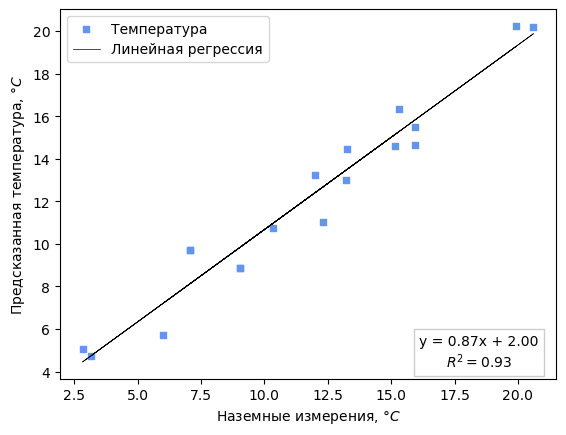

In [ ]:
f, ax = plt.subplots()

plt.scatter(
   df_in_situ, 
   df_image,
   s=15,
   c='#6495ED',
   marker="s",
   label="Температура")

plt.plot(
    df_in_situ,
    regressor.predict(df_in_situ),
    linewidth=0.5,
    color='black',
    label="Линейная регрессия"
)
plt.xlabel(r"Наземные измерения, ${\degree}C$")
plt.ylabel(r"Предсказанная температура, ${\degree}C$")
plt.legend(loc="upper left")
plt.text(
   x=0.845,
   y=0.12,
   s=f"y = {regressor.coef_[0][0]:.2f}x + {regressor.intercept_[0]:.2f}\n$R^{{2}} = {r2:.2f}$",
   horizontalalignment='center',
   verticalalignment='top',
   transform = ax.transAxes, #
   bbox=dict(facecolor='white', alpha=0.2))

plt.show()

Демонстрация того, что даже, если снимок попадает в то время, когда были измерения, точка этих измерений может не попасть в снимок

In [20]:
satellite_demo = 'L9'
clouds_demo = 30
image_id_demo = 16
LandsatColl_demo = get_image_list(satellite_demo, clouds_demo)
demo_image = ee.Image(LandsatColl_demo.get(image_id_demo))
res_demo = find_entries_for_image(demo_image, df_lst, 15)
temp_entries = res_demo.mean()
print(float(temp_entries['T']))
temp_longtitude = float(temp_entries['Lon'])
temp_latitude = float(temp_entries['Lat'])
print(temp_longtitude)
print(temp_latitude)

TypeError: get_image_list() takes 1 positional argument but 2 were given

In [37]:
image_aa = ee.Image(get_image_list('L8').get(11))
region_point = ee.Geometry.Point([106.13721, 52.42599])

In [38]:
Map = geemap.Map()
# Map.addLayer(image_aa.clip(baikal_shape).select('Day_view_time'), name='LST_Day')
# Map.addLayer(image_aa.clip(baikal_shape).select('Night_view_time'), name='Night_Day')
Map.addLayer(image_aa.select('LST'), name='LST')
# Map.addLayer(region_bbox, name='BBox')
Map.addLayer(region_point, name='Point')
# Map.centerObject(region_point)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Пространственные оформить - медиана или среднее - Где в Байкале модис 11 и 12 сильнее отчличаются
Сценарии сравнить - графики изм-я 
Апвейлинг посмотреть - какая там тенденция

Тезисы общие: возмодность измерение темп со спутников и тенденция изменения темп (связанная с другими измненеиями темп), а также явления (воронки и пятна-апвейлинги)

Среднее в регионе

In [ ]:
from math import sqrt
from pygeodesy import ellipsoidalVincenty

north_west = 315
south_east = 135

def compute_geocoordinates_square(longitude: float, latitude: float, square_side: float) -> tuple[float, float, float, float]:
   '''Returns square boarders around (lon, lat) as west, south, east, north in degrees
   '''
   diagonal_to_corner = square_side * sqrt(2)

   lat_lon = ellipsoidalVincenty.LatLon(latitude, longitude)
   north_west_destination: ellipsoidalVincenty.LatLon = lat_lon.destination(diagonal_to_corner, north_west)
   south_east_destination: ellipsoidalVincenty.LatLon = lat_lon.destination(diagonal_to_corner, south_east)

   return north_west_destination.lon, south_east_destination.lat, south_east_destination.lon, north_west_destination.lat

def get_image_temperature_region(
      validation_entry: pd.Series, 
      image: ee.image, 
      averaging_square_side: int) -> pd.Series:
   '''Создаёт запись для валидации каждого измерения к изображению'''
   longtitude = validation_entry['Lon']
   latitude = validation_entry['Lat']

   region = ee.Geometry.Point([longtitude, latitude])
   image_temperature = image.reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=region
   ).getInfo()['LST']

   if(image_temperature is None):
   # Если значение не нашлось в точки - ищи в регионе
      west_border, south_border, east_border, north_border = compute_geocoordinates_square(
         longtitude, 
         latitude, 
         square_side=averaging_square_side)
      region = ee.Geometry.BBox(west_border, south_border, east_border, north_border)

      image_temperature = image.reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=region
         ).getInfo()['LST']

   validation_entry['Image T'] = image_temperature
   return validation_entry

def get_validation_entries_region(
      image: ee.Image, 
      df: pd.DataFrame, 
      minutes_padding: int, 
      averaging_square_side: int) -> pd.DataFrame:
   '''Создаёт записи для валидации, рассматривая каждое измерение как отдельную запись'''
   found_entries = find_entries_for_image(image, df, minutes_padding)
   found_entries['Image T'] = None
   if(found_entries.shape[0] == 0): # Если нет строк - не нашли подходящих измерений
      return found_entries
   print(f"Найдено {found_entries.shape[0]} измерений")

   found_entries.apply(
      get_image_temperature_region, 
      axis=1,
      image=image,
      averaging_square_side=averaging_square_side)
   found_entries.drop(found_entries[found_entries['Image T'] == None].index, inplace=True)
   print(f"Подошло {found_entries.shape[0]} измерений для валидации")

   return found_entries

In [ ]:
image = ee.Image(get_image_list('L8').get(11))
found_entries = find_entries_for_image(image, df_lst, 15)
averaged_entry = found_entries.mean()

average_longtitude = float(averaged_entry['Lon'])
average_latitude = float(averaged_entry['Lat'])

west_border, south_border, east_border, north_border = compute_geocoordinates_square(
   average_longtitude, 
   average_latitude, 
   square_side=10)

region_bbox = ee.Geometry.BBox(west_border, south_border, east_border, north_border)

image_temperature = image.reduceRegion(
   reducer=ee.Reducer.mean(),
   geometry=region_bbox
).getInfo()['LST']
image_temperature